# Plot spatial trends in sea ice loss, ASR, and OLR

### Will need to compute trends over entire lat-lon Arctic subset (potentially slow)

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load datasets

CERES, GISStemp, NSIDC G10010

## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [2]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [3]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [4]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [5]:
giss1.close()

## Load NSIDC data

Using the G10010 V2 product for now.

The ancilliary data has the lat/lon point for each gridcell

In [6]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [7]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))
# nsidc_seaice = nsidc_seaice.sel(time=slice('2001-01-01','2017-12-31'))

Using the G02202 V4 product (recommended by Walt Meier)

## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [8]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [9]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data
if os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
    ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)
    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)) or (not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
    
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
        ceres_asr = all_ceres['solar_mon'] - all_ceres['toa_sw_all_mon']
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [10]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

In [11]:
def vectorized_linregress(data):
    '''
    Package for my vectorized linregress call. Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
    linregress1d_np,  # first the function
    data,  # now arguments in the order expected by 'regress1_np'
    data.year,
    input_core_dims=[["year"], ["year"],],
    output_core_dims= [[] for _ in range(5)],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[data.dtype for _ in range(5)], # one per output
    )
    
    return regressed_month

In [12]:
def compute_trends_n_signif(subset_data):
    '''
    Package the trend calculating lines to save space.
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time'))
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):

        _yearlydata = _month.groupby('time.year').mean('time')    
        regressed_month = vectorized_linregress(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        _trends[ii] = regressed_month[0]
        _rvalues[ii] = regressed_month[2]
        _pvalues[ii] = regressed_month[3]

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Calculate trends and statistical significance

#### CERES ASR

In [18]:
if os.path.exists('/glade/work/jonahshaw/spectral_ice_files/asr_spatial_trends.nc'):
    all_asr_data = xr.open_dataset('/glade/work/jonahshaw/spectral_ice_files/asr_spatial_trends.nc')
    
else:
    ceres_asr_subset = ceres_asr['ASR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90))
    asr_trends,asr_statsig,asr_notnull = compute_trends_n_signif(ceres_asr_subset)
    
    all_asr_data = xr.merge([asr_trends.rename('TREND'),asr_statsig.rename('STATSIG'),asr_notnull.rename('NOTNULL')])
    all_asr_data.to_netcdf('/glade/work/jonahshaw/spectral_ice_files/asr_spatial_trends.nc')

#### CERES OLR

In [23]:
if os.path.exists('/glade/work/jonahshaw/spectral_ice_files/olr_spatial_trends.nc'):
    all_olr_data = xr.open_dataset('/glade/work/jonahshaw/spectral_ice_files/olr_spatial_trends.nc')
    
else:
    ceres_olr_subset = ceres_olr['OLR'].sel(time=slice('2001-01-01','2020-12-31'),lat=slice(58,90))
    olr_trends,olr_statsig,olr_notnull = compute_trends_n_signif(ceres_olr_subset)

    all_olr_data = xr.merge([olr_trends.rename('TREND'),olr_statsig.rename('STATSIG'),olr_notnull.rename('NOTNULL')])
    all_olr_data.to_netcdf('/glade/work/jonahshaw/spectral_ice_files/olr_spatial_trends.nc')

#### Temperature from GISStemp

In [25]:
if os.path.exists('/glade/work/jonahshaw/spectral_ice_files/gisstemp_spatial_trends.nc'):
    all_gisstemp_data = xr.open_dataset('/glade/work/jonahshaw/spectral_ice_files/gisstemp_spatial_trends.nc')
    
else:
    gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58))
    gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif(gisstemp_subset)

    all_gisstemp_data = xr.merge([gisstemp_trends.rename('TREND'),gisstemp_statsig.rename('STATSIG'),gisstemp_notnull.rename('NOTNULL')])
    all_gisstemp_data.to_netcdf('/glade/work/jonahshaw/spectral_ice_files/gisstemp_spatial_trends.nc')

#### Ice Concentration from NSIDC G10010

In [27]:
if os.path.exists('/glade/work/jonahshaw/spectral_ice_files/g10010_spatial_trends.nc'):
    all_g10010_data = xr.open_dataset('/glade/work/jonahshaw/spectral_ice_files/g10010_spatial_trends.nc')
    
else:
    try:
        nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
    except:
        pass

    # Subset by time and latitude
    g10010_tsel = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))
    g10010_subset = g10010_tsel.where(g10010_tsel['LandRegion_mask']!=20)

    g10010_trends,g10010_statsig,g10010_notnull = compute_trends_n_signif(g10010_subset['seaice_conc'])

    all_g10010_data = xr.merge([g10010_trends.rename('TREND'),g10010_statsig.rename('STATSIG'),g10010_notnull.rename('NOTNULL')])
    all_g10010_data.to_netcdf('/glade/work/jonahshaw/spectral_ice_files/g10010_spatial_trends.nc')

### Make polar plots

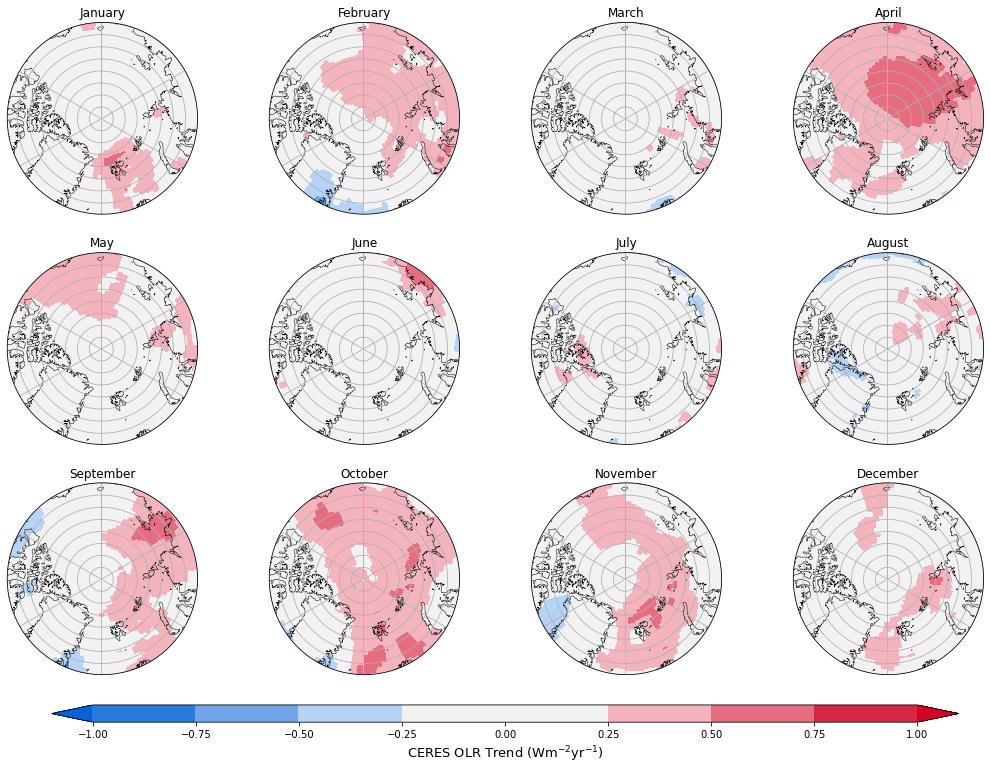

In [68]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

for i,(ax,month) in enumerate(zip(axs.flat,olr_trends)):
    polarCentral_set_latlim([70,90], ax)
#     print(month.shape)
#     break
#     im = out.where(out.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),cmap=palette,levels=np.linspace(-1,1,9),extend='both',vmin=-1.0,vmax=1)
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=12)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)

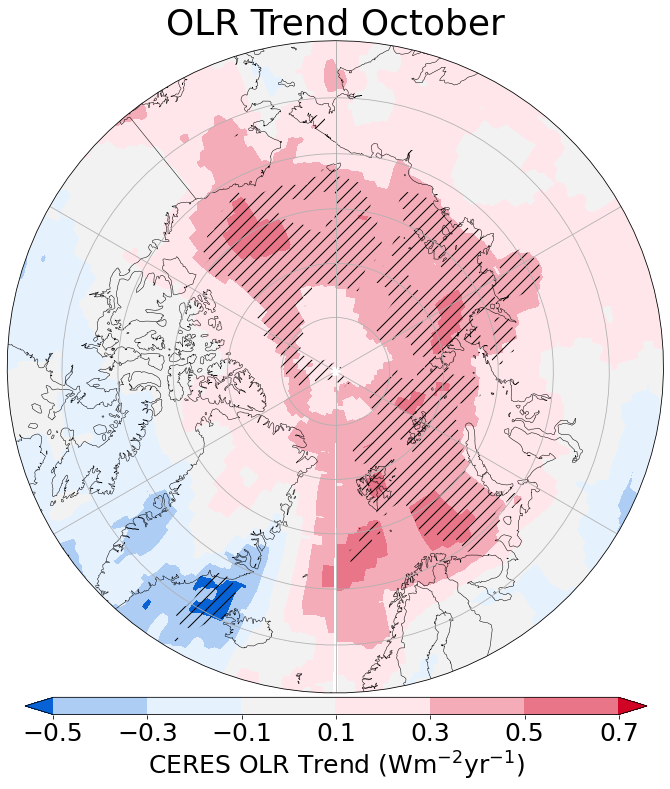

In [32]:
fig_olr,axs = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

polarCentral_set_latlim([60,90], axs)

olr_trend_oct = all_olr_data['TREND'][9]
olr_statsig_oct = all_olr_data['STATSIG'][9]

im = axs.contourf(olr_trend_oct['lon'],olr_trend_oct['lat'],olr_trend_oct,transform=ccrs.PlateCarree(),cmap=palette,levels=np.arange(-0.5,0.71,0.2),extend='both',vmin=-1.0,vmax=1)

stip = axs.contourf(olr_statsig_oct['lon'],olr_statsig_oct['lat'],olr_statsig_oct, transform=ccrs.PlateCarree(), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')

add_map_features(axs)

# label = mon_dict[str(10)]
label = 'OLR Trend October'

axs.set_title(label,fontsize=36)

cbar_axh = fig_olr.add_axes([0.273, 0.1, 0.48, 0.02])
cbar1 = fig_olr.colorbar(im,cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=25)
cbar1.ax.tick_params(labelsize=25)

In [33]:
to_png(fig_olr,'olr_trends_spatial_arcproj')

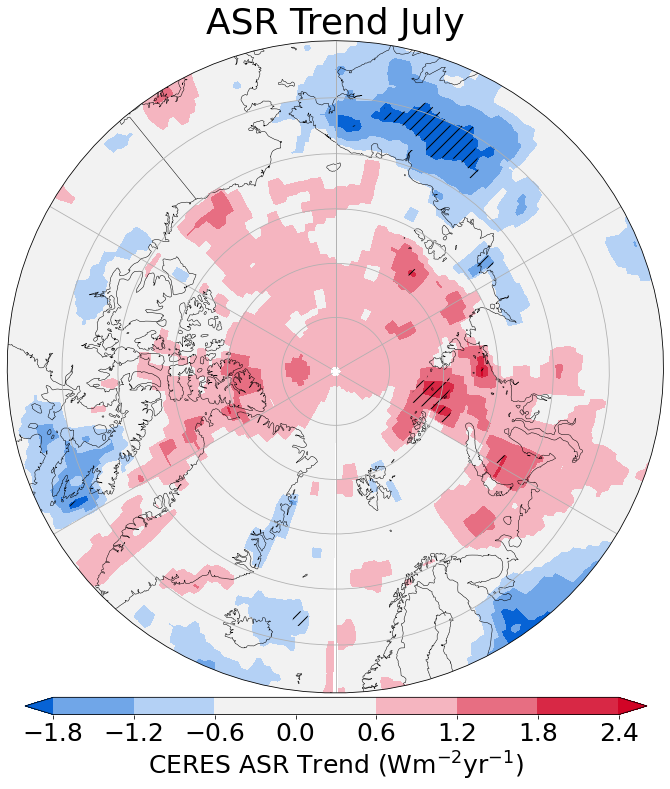

In [36]:
fig_asr,axs = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

polarCentral_set_latlim([60,90], axs)

asr_trend_july = all_asr_data['TREND'][6]
asr_statsig_july = all_asr_data['STATSIG'][6]

im = axs.contourf(asr_trend_july['lon'],asr_trend_july['lat'],asr_trend_july,transform=ccrs.PlateCarree(),
                  levels=np.arange(-1.8,2.41,0.6),cmap=palette,extend='both',vmin=-2.4,vmax=2.4) # np.arange(-1.8,2.41,0.6)

stip = axs.contourf(asr_statsig_july['lon'],asr_statsig_july['lat'],asr_statsig_july, transform=ccrs.PlateCarree(), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')

add_map_features(axs)

# label = mon_dict[str(10)]
label = 'ASR Trend July'

axs.set_title(label,fontsize=36)

cbar_axh = fig_asr.add_axes([0.273, 0.1, 0.48, 0.02])
cbar1 = fig_asr.colorbar(im,cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES ASR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=25)
cbar1.ax.tick_params(labelsize=25)

In [37]:
to_png(fig_asr,'asr_trends_spatial_arcproj')

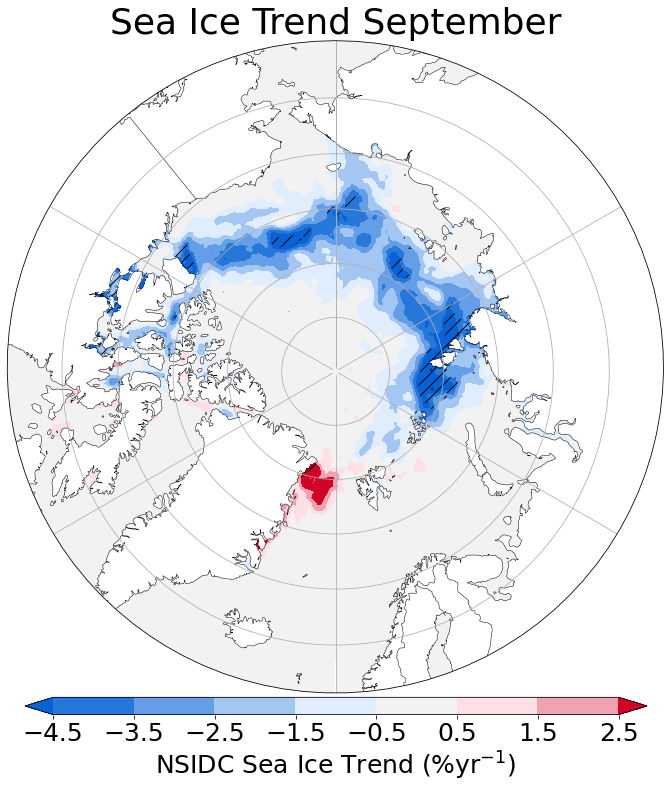

In [38]:
fig_seaice,axs = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

polarCentral_set_latlim([60,90], axs)

seaice_trend_sept = all_g10010_data['TREND'][8]
seaice_statsig_sept = all_g10010_data['STATSIG'][8]

im = axs.contourf(seaice_trend_sept['lon'],seaice_trend_sept['lat'],seaice_trend_sept,transform=ccrs.PlateCarree(),cmap=palette,extend='both',
                  vmin=-4.5,vmax=4.5,levels=np.arange(-4.5,2.51,1))
#                   levels=np.arange(-1.8,2.41,0.6),cmap=palette,extend='both',vmin=-2.4,vmax=2.4)

stip = axs.contourf(seaice_statsig_sept['lon'],seaice_statsig_sept['lat'],seaice_statsig_sept, transform=ccrs.PlateCarree(), colors='none',levels=[0,99,100],
                        hatches=[None,'//'],extend='neither')

add_map_features(axs)

# label = mon_dict[str(10)]
label = 'Sea Ice Trend September'

axs.set_title(label,fontsize=36)

cbar_axh = fig_seaice.add_axes([0.273, 0.1, 0.48, 0.02])
cbar1 = fig_seaice.colorbar(im,cax=cbar_axh,orientation='horizontal')

cbar1.set_label("NSIDC Sea Ice Trend (%yr$^{-1}$)",fontsize=25)
cbar1.ax.tick_params(labelsize=25)

In [39]:
to_png(fig_seaice,'seaice_trends_spatial_arcproj')